In [1]:
!python -V

Python 3.9.19


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [8]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2024/05/11 00:58:44 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/mnt/d/fiqih-cobs/personal/Learn/MLOPS-Zoomcamp/2-experiment-tracking/mlruns/1', creation_time=1715363924380, experiment_id='1', last_update_time=1715363924380, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [9]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [10]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829628

/tmp/ipykernel_19833/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_19833/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


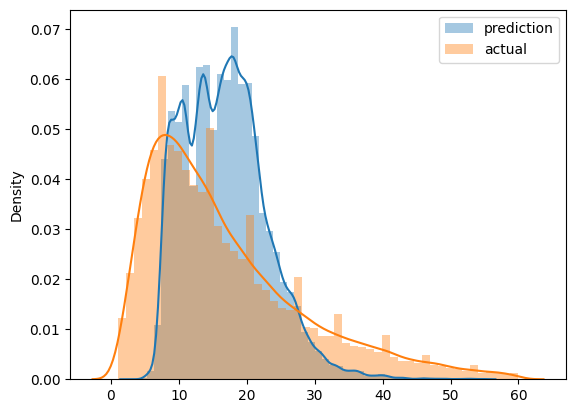

In [11]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [12]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [14]:
len(df_train), len(df_val)

(73908, 61921)

In [15]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [16]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715205596356

In [20]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [22]:
with mlflow.start_run():
    mlflow.set_tag("Developer","Fiqih Fathor Rachim")

    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")
    alpha = 0.01
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rsme = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse",rsme)

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [23]:
import xgboost as xgb

In [24]:

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [25]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [26]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [27]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:19:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.53606                           
[1]	validation-rmse:7.18726                           
[2]	validation-rmse:6.73670                           
[3]	validation-rmse:6.57123                           
[4]	validation-rmse:6.50197                           
[5]	validation-rmse:6.46818                           
[6]	validation-rmse:6.44828                           
[7]	validation-rmse:6.44050                           
[8]	validation-rmse:6.43578                           
[9]	validation-rmse:6.42735                           
[10]	validation-rmse:6.42340                          
[11]	validation-rmse:6.42033                          
[12]	validation-rmse:6.41529                          
[13]	validation-rmse:6.41027                          
[14]	validation-rmse:6.40636                          
[15]	validation-rmse:6.40213                          
[16]	validation-rmse:6.39805                          
[17]	validation-rmse:6.39683                          
[18]	valid

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:19:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.08270                                                   
[1]	validation-rmse:10.16165                                                   
[2]	validation-rmse:9.41700                                                    
[3]	validation-rmse:8.81964                                                    
[4]	validation-rmse:8.34489                                                    
[5]	validation-rmse:7.97064                                                    
[6]	validation-rmse:7.67572                                                    
[7]	validation-rmse:7.44567                                                    
[8]	validation-rmse:7.26530                                                    
[9]	validation-rmse:7.12232                                                    
[10]	validation-rmse:7.01104                                                   
[11]	validation-rmse:6.92376                                                   
[12]	validation-rmse:6.85530            

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:21:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.24531                                                    
[1]	validation-rmse:7.82180                                                    
[2]	validation-rmse:7.18278                                                    
[3]	validation-rmse:6.89999                                                    
[4]	validation-rmse:6.76522                                                    
[5]	validation-rmse:6.70051                                                    
[6]	validation-rmse:6.66120                                                    
[7]	validation-rmse:6.63965                                                    
[8]	validation-rmse:6.62395                                                    
[9]	validation-rmse:6.61283                                                    
[10]	validation-rmse:6.60208                                                   
[11]	validation-rmse:6.59265                                                   
[12]	validation-rmse:6.58989            

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:22:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.08625                                                    
[1]	validation-rmse:7.68205                                                    
[2]	validation-rmse:7.08610                                                    
[3]	validation-rmse:6.82435                                                    
[4]	validation-rmse:6.70354                                                    
[5]	validation-rmse:6.64089                                                    
[6]	validation-rmse:6.61151                                                    
[7]	validation-rmse:6.59018                                                    
[8]	validation-rmse:6.57671                                                    
[9]	validation-rmse:6.56793                                                    
[10]	validation-rmse:6.56506                                                   
[11]	validation-rmse:6.56179                                                   
[12]	validation-rmse:6.55604            

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:22:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.73890                                                   
[1]	validation-rmse:11.29984                                                   
[2]	validation-rmse:10.89397                                                   
[3]	validation-rmse:10.51919                                                   
[4]	validation-rmse:10.17310                                                   
[5]	validation-rmse:9.85405                                                    
[6]	validation-rmse:9.56094                                                    
[7]	validation-rmse:9.29205                                                    
[8]	validation-rmse:9.04452                                                    
[9]	validation-rmse:8.81808                                                    
[10]	validation-rmse:8.60995                                                   
[11]	validation-rmse:8.41911                                                   
[12]	validation-rmse:8.24635            

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:25:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.53086                                                     
[1]	validation-rmse:9.32665                                                      
[2]	validation-rmse:8.48045                                                      
[3]	validation-rmse:7.89607                                                      
[4]	validation-rmse:7.49962                                                      
[5]	validation-rmse:7.23091                                                      
[6]	validation-rmse:7.05017                                                      
[7]	validation-rmse:6.92428                                                      
[8]	validation-rmse:6.83757                                                      
[9]	validation-rmse:6.77667                                                      
[10]	validation-rmse:6.73560                                                     
[11]	validation-rmse:6.70417                                                     
[12]	validation-

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:26:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.29827                                                      
[1]	validation-rmse:7.85969                                                      
[2]	validation-rmse:7.18903                                                      
[3]	validation-rmse:6.88748                                                      
[4]	validation-rmse:6.74123                                                      
[5]	validation-rmse:6.66503                                                      
[6]	validation-rmse:6.62083                                                      
[7]	validation-rmse:6.59697                                                      
[8]	validation-rmse:6.58187                                                      
[9]	validation-rmse:6.57145                                                      
[10]	validation-rmse:6.56099                                                     
[11]	validation-rmse:6.55790                                                     
[12]	validation-

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:27:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.19581                                                   
[1]	validation-rmse:10.35022                                                   
[2]	validation-rmse:9.65154                                                    
[3]	validation-rmse:9.07945                                                    
[4]	validation-rmse:8.61424                                                    
[5]	validation-rmse:8.23764                                                    
[6]	validation-rmse:7.93427                                                    
[7]	validation-rmse:7.69085                                                    
[8]	validation-rmse:7.49521                                                    
[9]	validation-rmse:7.33915                                                    
[10]	validation-rmse:7.21487                                                   
[11]	validation-rmse:7.11509                                                   
[12]	validation-rmse:7.03547            

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:29:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.62669                                                      
[1]	validation-rmse:6.56469                                                      
[2]	validation-rmse:6.56459                                                      
[3]	validation-rmse:6.55256                                                      
[4]	validation-rmse:6.53987                                                      
[5]	validation-rmse:6.53036                                                      
[6]	validation-rmse:6.52356                                                      
[7]	validation-rmse:6.51545                                                      
[8]	validation-rmse:6.51384                                                      
[9]	validation-rmse:6.51022                                                      
[10]	validation-rmse:6.51100                                                     
[11]	validation-rmse:6.50744                                                     
[12]	validation-

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:29:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.72680                                                   
[1]	validation-rmse:11.27825                                                   
[2]	validation-rmse:10.86522                                                   
[3]	validation-rmse:10.48582                                                   
[4]	validation-rmse:10.13752                                                   
[5]	validation-rmse:9.81835                                                    
[6]	validation-rmse:9.52623                                                    
[7]	validation-rmse:9.25910                                                    
[8]	validation-rmse:9.01515                                                    
[9]	validation-rmse:8.79325                                                    
[10]	validation-rmse:8.59125                                                   
[11]	validation-rmse:8.40747                                                   
[12]	validation-rmse:8.24073            

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:33:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.40544                                                       
[1]	validation-rmse:9.14617                                                        
[2]	validation-rmse:8.30196                                                        
[3]	validation-rmse:7.71988                                                        
[4]	validation-rmse:7.33316                                                        
[5]	validation-rmse:7.09397                                                        
[6]	validation-rmse:6.93116                                                        
[7]	validation-rmse:6.81586                                                        
[8]	validation-rmse:6.73243                                                        
[9]	validation-rmse:6.67473                                                        
[10]	validation-rmse:6.63173                                                       
[11]	validation-rmse:6.60513                                                

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:34:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.01385                                                      
[1]	validation-rmse:10.05083                                                      
[2]	validation-rmse:9.28471                                                       
[3]	validation-rmse:8.68105                                                       
[4]	validation-rmse:8.21002                                                       
[5]	validation-rmse:7.84458                                                       
[6]	validation-rmse:7.56309                                                       
[7]	validation-rmse:7.34673                                                       
[8]	validation-rmse:7.18006                                                       
[9]	validation-rmse:7.05081                                                       
[10]	validation-rmse:6.95197                                                      
[11]	validation-rmse:6.87603                                                      
[12]

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:35:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.44620                                                    
[1]	validation-rmse:10.77374                                                    
[2]	validation-rmse:10.18989                                                    
[3]	validation-rmse:9.67503                                                     
[4]	validation-rmse:9.23891                                                     
[5]	validation-rmse:8.84209                                                     
[6]	validation-rmse:8.51818                                                     
[7]	validation-rmse:8.23011                                                     
[8]	validation-rmse:7.98767                                                     
[9]	validation-rmse:7.78348                                                     
[10]	validation-rmse:7.60670                                                    
[11]	validation-rmse:7.45542                                                    
[12]	validation-rmse:7.32705

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:38:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.73626                                                        
[1]	validation-rmse:7.40685                                                        
[2]	validation-rmse:6.93732                                                        
[3]	validation-rmse:6.76292                                                        
[4]	validation-rmse:6.68786                                                        
[5]	validation-rmse:6.65412                                                        
[6]	validation-rmse:6.63297                                                        
[7]	validation-rmse:6.62177                                                        
[8]	validation-rmse:6.61705                                                        
[9]	validation-rmse:6.61151                                                        
[10]	validation-rmse:6.60457                                                       
[11]	validation-rmse:6.60029                                                

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/mnt/d/fiqih-cobs/python_env/wsl-personal-mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [01:39:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.96494                                                    
[1]	validation-rmse:9.97212                                                     
[2]	validation-rmse:9.18792                                                     
[3]	validation-rmse:8.57576                                                     
[4]	validation-rmse:8.10289                                                     
 28%|██▊       | 14/50 [19:50<51:01, 85.05s/trial, best loss: 6.328527178020857]


KeyboardInterrupt: 

In [28]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

FileNotFoundError: [Errno 2] No such file or directory: 'models/preprocessor.b'